
# **Image Semantic Segmentation** <small>V0.3.6 (TF 2.8)

---
**Streamlined version of the ZeroCostDL4Mic Notebook U-Net_2D_Multilabel**   



*Daniel Sage, EPFL, Lausanne, Switzerland*

**Disclaimer:** The original notebook is part of the [ZeroCostDL4Mic](https://github.com/HenriquesLab/DeepLearning_Collab/wiki)  project which is developed by the [G. Jacquemet Lab](https://cellmig.org/) and [R. Henriques Lab](https://henriqueslab.github.io/). The carbon emission are estimated by [CodeCarbon](http://codecarbon.io/).

Compare to the original version, we have done the following modification: Reading TIF and PNG, add CodeCarbon Tracking, remove general text


---

This goal of this notebook is to show step-by-step the operations to train a neural network U-net for image semantic segmentation (pixel classification). At the end,the model is exported in the Bioimage Model Zoo format and directly usable in deepImageJ.

**References to cite**
- [U-Net](https://arxiv.org/abs/1505.04597) Ronneberger et al. MICCAI 2015.
- [ZeroCostDL4Mic](https://www.nature.com/articles/s41467-021-22518-0): L. von Chamier et al., Nature Methods, 2021.
- [Bioimage Model Zoo (BMZ)](https://www.biorxiv.org/content/10.1101/2022.06.07.495102v1) W. Ouyang et al., biorxiv  2022.
- [DeepImageJ](https://doi.org/10.1038/s41592-021-01262-9): E. Gómez-de-Mariscal et al., Nature Methods 2021. deepImage team


# **0. Before to Start**

### **Requirements**

**Environment**

This notebook is designed to run on Google Colab which is required a Google account.

- Save this notebook on your Google Drive
- Rename it
- Clear all outputs (menu Edit)
- Restart runtime (menu Runtime)


**Datasets**

The U-Net training required two paired datasets stored on your Google Drive, one for the training <code>**train**</code> and one for the quality control <code>**test**</code>

- <code>**sources**</code> list of raw images.

- <code>**targets**</code> list of ground-truth images, masks, labels or annotated images. The target should contain a class number [0, 1, 2, ...] corresponding to each compartment to segment.

<code>

    datasetName/
    ├─── train/
    │    ├─── sources/
    │    │    ─ 0001.tif, 0002.tif, ...
    │    └─── targets
    │         ─ 0001.tif, 0002.tif, ...
    │─── test
    │    ├─── sources
    │    │    ─ 0001.tif, 0002.tif, ...
    │    └─── targets
    │         ─ 0001.tif, 0002.tif, ...
    └─── unseen
         ├─── sources
              ─ 0001.tif, 0002.tif, ...
</code>



## **Usages**

  - **Train from scratch on your own dataset**: Run sections 1 - 5

  - **Fine-tuning with on your own dataset**: Run sections 1 - 5, provide the existing a pre-trained model in section 3.3.

  - **Evaluate a model**: Run sections 1-2 then section 5

  - **Prediction**: Run sections 1-2, then section 6

# **1. Installation**
---


In [17]:
#@markdown ##**1.1 Install dependencies**
# Install packages which are not included in Google Colab
!pip install data
!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q wget
!pip install -q fpdf2
!pip install -q PTable # Nice tables
!pip install -q zarr
!pip install -q imagecodecs
!pip install "bioimageio.core>=0.5,<0.6"

!pip install tensorflow==2.8
import tensorflow as tf
print(tf.__version__)


ERROR: Could not find a version that satisfies the requirement tensorflow==2.7 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.15.0rc0, 2.15.0rc1)
ERROR: No matching distribution found for tensorflow==2.7
2.8.0


In [1]:
#@markdown ##**1.2 Define the Core Functions**

from __future__ import print_function
Notebook_version = '2.1.1'
Network = 'U-Net (2D) multilabel'

from builtins import any as b_any

def get_requirements_path():
    # Store requirements file in 'contents' directory
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path)
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list]
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item)

    file.close()

import sys
before = [str(m) for m in sys.modules]

#As this notebokk depends mostly on keras which runs a tensorflow backend (which in turn is pre-installed in colab)
#only the data library needs to be additionally installed.
import tensorflow as tf

# Keras imports
from tensorflow.keras import models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger # we currently don't use any other callbacks from ModelCheckpoints
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import Callback

# General import
import numpy as np
import pandas as pd
import os
import glob
from skimage import img_as_ubyte, io, transform
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
from pathlib import Path
import shutil
import random
import time
import csv
import sys
from math import ceil
from fpdf import FPDF, HTMLMixin
from pip._internal.operations.freeze import freeze
import subprocess
# Imports for QC
from PIL import Image
from scipy import signal
from scipy import ndimage
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr

# For sliders and dropdown menu and progress bar
from ipywidgets import interact
import ipywidgets as widgets
# from tqdm import tqdm
from tqdm.notebook import tqdm
from sklearn.feature_extraction import image
from skimage import img_as_ubyte, io, transform
from skimage.util.shape import view_as_windows
from datetime import datetime

# Suppressing some warnings
import warnings
warnings.filterwarnings('ignore')

# BioImage Model Zoo
from shutil import rmtree
from bioimageio.core.build_spec import build_model, add_weights
from bioimageio.core.resource_tests import test_model
from bioimageio.core.weight_converter.keras import convert_weights_to_tensorflow_saved_model_bundle
from bioimageio.core import load_raw_resource_description, load_resource_description
from zipfile import ZipFile
import requests

#Create a variable to get and store relative base path
base_path = os.getcwd()

def create_patches(Training_source, Training_target, patch_width, patch_height, min_fraction):
  """
  Function creates patches from the Training_source and Training_target images.
  The steps parameter indicates the offset between patches and, if integer, is the same in x and y.
  Saves all created patches in two new directories in the base_path folder.

  Returns: - Two paths to where the patches are now saved
  """
  DEBUG = False

  Patch_source = os.path.join(base_path,'img_patches')
  Patch_target = os.path.join(base_path,'mask_patches')
  Patch_rejected = os.path.join(base_path,'rejected')

  #Here we save the patches, in the /content directory as they will not usually be needed after training
  if os.path.exists(Patch_source):
    shutil.rmtree(Patch_source)
  if os.path.exists(Patch_target):
    shutil.rmtree(Patch_target)
  if os.path.exists(Patch_rejected):
    shutil.rmtree(Patch_rejected)

  os.mkdir(Patch_source)
  os.mkdir(Patch_target)
  os.mkdir(Patch_rejected) #This directory will contain the images that have too little signal.

  patch_num = 0

  for file in tqdm(os.listdir(Training_source)):

    img = io.imread(os.path.join(Training_source, file))
    mask = io.imread(os.path.join(Training_target, file),as_gray=True)

    if DEBUG:
      print(file)
      print(img.dtype)

    # Using view_as_windows with step size equal to the patch size to ensure there is no overlap
    patches_img = view_as_windows(img, (patch_width, patch_height), (patch_width, patch_height))
    patches_mask = view_as_windows(mask, (patch_width, patch_height), (patch_width, patch_height))

    patches_img = patches_img.reshape(patches_img.shape[0]*patches_img.shape[1], patch_width,patch_height)
    patches_mask = patches_mask.reshape(patches_mask.shape[0]*patches_mask.shape[1], patch_width,patch_height)

    if DEBUG:
      print(all_patches_img.shape)
      print(all_patches_img.dtype)

    for i in range(patches_img.shape[0]):
      img_save_path = os.path.join(Patch_source,'patch_'+str(patch_num)+'.tif')
      mask_save_path = os.path.join(Patch_target,'patch_'+str(patch_num)+'.tif')
      patch_num += 1

      # if the mask conatins at least 2% of its total number pixels as mask, then go ahead and save the images
      pixel_threshold_array = sorted(patches_mask[i].flatten())
      if pixel_threshold_array[int(round((len(pixel_threshold_array)-1)*(1-min_fraction)))]>0:
        io.imsave(img_save_path, img_as_ubyte(normalizeMinMax(patches_img[i])))
        io.imsave(mask_save_path, patches_mask[i])
      else:
        io.imsave(Patch_rejected+'/patch_'+str(patch_num)+'_image.tif', img_as_ubyte(normalizeMinMax(patches_img[i])))
        io.imsave(Patch_rejected+'/patch_'+str(patch_num)+'_mask.tif', patches_mask[i])

  return Patch_source, Patch_target

def estimatePatchSize(data_path, max_width = 512, max_height = 512):

  files = os.listdir(data_path)

  # Get the size of the first image found in the folder and initialise the variables to that
  n = 0
  while os.path.isdir(os.path.join(data_path, files[n])):
    n += 1
  (height_min, width_min) = Image.open(os.path.join(data_path, files[n])).size

  # Screen the size of all dataset to find the minimum image size
  for file in files:
    if not os.path.isdir(os.path.join(data_path, file)):
      (height, width) = Image.open(os.path.join(data_path, file)).size
      if width < width_min:
        width_min = width
      if height < height_min:
        height_min = height

  # Find the power of patches that will fit within the smallest dataset
  width_min, height_min = (fittingPowerOfTwo(width_min), fittingPowerOfTwo(height_min))

  # Clip values at maximum permissible values
  if width_min > max_width:
    width_min = max_width

  if height_min > max_height:
    height_min = max_height

  return (width_min, height_min)

def fittingPowerOfTwo(number):
  n = 0
  while 2**n <= number:
    n += 1
  return 2**(n-1)

## TODO: create weighted CE for semantic labels
def getClassWeights(Training_target_path):

  Mask_dir_list = os.listdir(Training_target_path)
  number_of_dataset = len(Mask_dir_list)

  class_count = np.zeros(2, dtype=int)
  for i in tqdm(range(number_of_dataset)):
    mask = io.imread(os.path.join(Training_target_path, Mask_dir_list[i]))
    mask = normalizeMinMax(mask)
    class_count[0] += mask.shape[0]*mask.shape[1] - mask.sum()
    class_count[1] += mask.sum()

  n_samples = class_count.sum()
  n_classes = 2

  class_weights = n_samples / (n_classes * class_count)
  return class_weights

def weighted_binary_crossentropy(class_weights):

    def _weighted_binary_crossentropy(y_true, y_pred):
        binary_crossentropy = keras.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * class_weights[1] + (1. - y_true) * class_weights[0]
        weighted_binary_crossentropy = weight_vector * binary_crossentropy

        return keras.mean(weighted_binary_crossentropy)

    return _weighted_binary_crossentropy

def save_augment(datagen,orig_img,dir_augmented_data = base_path + "/augment"):
  """
  Saves a subset of the augmented data for visualisation, by default in /content.

  This is adapted from: https://fairyonice.github.io/Learn-about-ImageDataGenerator.html

  """
  try:
    os.mkdir(dir_augmented_data)
  except:
        ## if the preview folder exists, then remove
        ## the contents (pictures) in the folder
    for item in os.listdir(dir_augmented_data):
      os.remove(dir_augmented_data + "/" + item)

    ## convert the original image to array
  x = img_to_array(orig_img)
    ## reshape (Sampke, Nrow, Ncol, 3) 3 = R, G or B
    #print(x.shape)
  x = x.reshape((1,) + x.shape)
    #print(x.shape)
    ## -------------------------- ##
    ## randomly generate pictures
    ## -------------------------- ##
  i = 0
    #We will just save 5 images,
    #but this can be changed, but note the visualisation in 3. currently uses 5.
  Nplot = 5
  for batch in datagen.flow(x,batch_size=1,
                            save_to_dir=dir_augmented_data,
                            save_format='tif',
                            seed=42):
    i += 1
    if i > Nplot - 1:
      break

# Generators
def buildDoubleGenerator(image_datagen, mask_datagen, image_folder_path, mask_folder_path, subset, batch_size, target_size, validatio_split):
  '''
  Can generate image and mask at the same time use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same

  datagen: ImageDataGenerator
  subset: can take either 'training' or 'validation'
  '''

  # Build the dict for the ImageDataGenerator
  # non_aug_args = dict(width_shift_range = 0,
  #                     height_shift_range = 0,
  #                     rotation_range = 0, #90
  #                     zoom_range = 0,
  #                     shear_range = 0,
  #                     horizontal_flip = False,
  #                     vertical_flip = False,
  #                     fill_mode = 'reflect')
  # default params of data generator is without augmentation
  mask_load_gen = ImageDataGenerator(dtype='uint8', validation_split=validatio_split)
  image_load_gen = ImageDataGenerator(dtype='float32', validation_split=validatio_split, preprocessing_function = normalizePercentile)

  image_generator = image_load_gen.flow_from_directory(
        os.path.dirname(image_folder_path),
        classes = [os.path.basename(image_folder_path)],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        subset = subset,
        interpolation = "bicubic",
        seed = 1)
  mask_generator = mask_load_gen.flow_from_directory(
        os.path.dirname(mask_folder_path),
        classes = [os.path.basename(mask_folder_path)],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        subset = subset,
        interpolation = "nearest",
        seed = 1)

  this_generator = zip(image_generator, mask_generator)
  for (img,mask) in this_generator:
      if subset == 'training':
          # Apply the data augmentation
          # the same seed should provide always the same transformation and image loading
          seed = np.random.randint(100000)
          for batch_im in image_datagen.flow(img,batch_size=batch_size, seed=seed):
              break
          mask = mask.astype(np.float32)
          labels = np.unique(mask)
          if len(labels)>1:
              batch_mask = np.zeros_like(mask, dtype='float32')
              for l in range(0, len(labels)):
                  aux = (mask==l).astype(np.float32)
                  for batch_aux in mask_datagen.flow(aux,batch_size=batch_size, seed=seed):
                      break
                  batch_mask += l*(batch_aux>0).astype(np.float32)
              index = np.where(batch_mask>l)
              batch_mask[index]=l
          else:
              batch_mask = mask

          yield (batch_im,batch_mask)

      else:
          yield (img,mask)


def prepareGenerators(image_folder_path, mask_folder_path, datagen_parameters, batch_size = 4, target_size = (512, 512), validatio_split = 0.1):
  image_datagen = ImageDataGenerator(**datagen_parameters, preprocessing_function = normalizePercentile)
  mask_datagen = ImageDataGenerator(**datagen_parameters)

  train_datagen = buildDoubleGenerator(image_datagen, mask_datagen, image_folder_path, mask_folder_path, 'training', batch_size, target_size, validatio_split)
  validation_datagen = buildDoubleGenerator(image_datagen, mask_datagen, image_folder_path, mask_folder_path, 'validation', batch_size, target_size, validatio_split)

  return (train_datagen, validation_datagen)


# Normalization functions from Martin Weigert
def normalizePercentile(x, pmin=1, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):#dtype=np.float32
    """This function is adapted from Martin Weigert"""
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x

# Simple normalization to min/max fir the Mask
def normalizeMinMax(x, dtype=np.float32):
  x = x.astype(dtype,copy=False)
  x = (x - np.amin(x)) / (np.amax(x) - np.amin(x) + 1e-10)
  return x

# This is code outlines the architecture of U-net. The choice of pooling steps decides the depth of the network.
def unet(pretrained_weights = None, input_size = (256,256,1), pooling_steps = 4, learning_rate = 1e-4, verbose=True, labels=2):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # Downsampling steps
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

    if pooling_steps > 1:
      pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
      conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
      conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

      if pooling_steps > 2:
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)

        if pooling_steps > 3:
          pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
          conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
          conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
          drop5 = Dropout(0.5)(conv5)

          #Upsampling steps
          up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
          merge6 = concatenate([drop4,up6], axis = 3)
          conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
          conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    if pooling_steps > 2:
      up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
      if pooling_steps > 3:
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
      merge7 = concatenate([conv3,up7], axis = 3)
      conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
      conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    if pooling_steps > 1:
      up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv3))
      if pooling_steps > 2:
        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
      merge8 = concatenate([conv2,up8], axis = 3)
      conv8 = Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
      conv8 = Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    if pooling_steps == 1:
      up9 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
    else:
      up9 = Conv2D(64, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8)) #activation = 'relu'

    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9) #activation = 'relu'
    conv9 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9) #activation = 'relu'
    conv9 = Conv2D(labels, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9) #activation = 'relu'
    conv10 = Conv2D(labels, 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = learning_rate), loss = 'sparse_categorical_crossentropy')

    if verbose:
      model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights);

    return model

# Custom callback showing sample prediction
class SampleImageCallback(Callback):

    def __init__(self, model, sample_data, model_path, save=False):
        self.model = model
        self.sample_data = sample_data
        self.model_path = model_path
        self.save = save

    def on_epoch_end(self, epoch, logs={}):
      if np.mod(epoch,5) == 0:
            sample_predict = self.model.predict_on_batch(self.sample_data)

            f=plt.figure(figsize=(16,8))
            plt.subplot(1,labels+1,1)
            plt.imshow(self.sample_data[0,:,:,0], cmap='gray')
            plt.title('Sample source')
            plt.axis('off');
            for i in range(1, labels):
              plt.subplot(1,labels+1,i+1)
              plt.imshow(sample_predict[0,:,:,i], interpolation='nearest', cmap='magma')
              plt.title('Predicted label {}'.format(i))
              plt.axis('off');

            plt.subplot(1,labels+1,labels+1)
            plt.imshow(np.squeeze(np.argmax(sample_predict[0], axis=-1)), interpolation='nearest')
            plt.title('Semantic segmentation')
            plt.axis('off');

            plt.show()

            if self.save:
                plt.savefig(self.model_path + '/epoch_' + str(epoch+1) + '.png')
                random_choice = random.choice(os.listdir(Patch_source))

def predict_as_tiles(Image_path, model):

  # Read the data in and normalize
  Image_raw = io.imread(Image_path, as_gray = True)
  Image_raw = normalizePercentile(Image_raw)

  # Get the patch size from the input layer of the model
  patch_size = model.layers[0].output_shape[0][1:3]

  # Pad the image with zeros if any of its dimensions is smaller than the patch size
  if Image_raw.shape[0] < patch_size[0] or Image_raw.shape[1] < patch_size[1]:
    Image = np.zeros((max(Image_raw.shape[0], patch_size[0]), max(Image_raw.shape[1], patch_size[1])))
    Image[0:Image_raw.shape[0], 0: Image_raw.shape[1]] = Image_raw
  else:
    Image = Image_raw

  # Calculate the number of patches in each dimension
  n_patch_in_width = ceil(Image.shape[0]/patch_size[0])
  n_patch_in_height = ceil(Image.shape[1]/patch_size[1])

  prediction = np.zeros(Image.shape, dtype = 'uint8')

  for x in range(n_patch_in_width):
    for y in range(n_patch_in_height):
      xi = patch_size[0]*x
      yi = patch_size[1]*y

      # If the patch exceeds the edge of the image shift it back
      if xi+patch_size[0] >= Image.shape[0]:
        xi = Image.shape[0]-patch_size[0]

      if yi+patch_size[1] >= Image.shape[1]:
        yi = Image.shape[1]-patch_size[1]

      # Extract and reshape the patch
      patch = Image[xi:xi+patch_size[0], yi:yi+patch_size[1]]
      patch = np.reshape(patch,patch.shape+(1,))
      patch = np.reshape(patch,(1,)+patch.shape)

      # Get the prediction from the patch and paste it in the prediction in the right place
      predicted_patch = model.predict(patch, batch_size = 1)
      prediction[xi:xi+patch_size[0], yi:yi+patch_size[1]] = (np.argmax(np.squeeze(predicted_patch), axis = -1)).astype(np.uint8)


  return prediction[0:Image_raw.shape[0], 0: Image_raw.shape[1]]

def saveResult(save_path, nparray, source_dir_list, prefix=''):
  for (filename, image) in zip(source_dir_list, nparray):
      prediction_filename = prefix+filename
      print(prediction_filename)
      io.imsave(os.path.join(save_path, prefix+filename), image) # saving as unsigned 8-bit image

def convert2Mask(image, threshold):
  mask = img_as_ubyte(image, force_copy=True)
  mask[mask > threshold] = 255
  mask[mask <= threshold] = 0
  return mask

# -------------- Other definitions -----------
W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red
prediction_prefix = ''


print('-------------------')
print('U-Net and dependencies installed.')

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'

# Check if this is the latest version of the notebook

All_notebook_versions = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_Notebook_versions.csv", dtype=str)
print('Notebook version: '+Notebook_version)
Latest_Notebook_version = All_notebook_versions[All_notebook_versions["Notebook"] == Network]['Version'].iloc[0]
print('Latest notebook version: '+Latest_Notebook_version)
#if Notebook_version == Latest_Notebook_version:
#  print("This notebook is up-to-date.")
#else:
#  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")


def pdf_export(trained = False, augmentation = False, pretrained_model = False):
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B')

  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Training report for '+Network+' model ('+model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L')
  pdf.ln(1)

  # add another cell
  if trained:
    training_time = "Training time: "+str(hour)+ "hour(s) "+str(mins)+"min(s) "+str(round(sec))+"sec(s)"
    pdf.cell(190, 5, txt = training_time, ln = 1, align='L')
  pdf.ln(1)

  Header_2 = 'Information for your materials and method:'
  pdf.cell(190, 5, txt=Header_2, ln=1, align='L')
  pdf.ln(1)

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '
  #print(all_packages)

  #Main Packages
  main_packages = ''
  version_numbers = []
  for name in ['tensorflow','numpy','keras']:
    find_name=all_packages.find(name)
    main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
    #Version numbers only here:
    version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

  cuda_version = subprocess.run('nvcc --version',stdout=subprocess.PIPE, shell=True)
  cuda_version = cuda_version.stdout.decode('utf-8')
  cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
  gpu_name = subprocess.run('nvidia-smi',stdout=subprocess.PIPE, shell=True)
  gpu_name = gpu_name.stdout.decode('utf-8')
  gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]
  #print(cuda_version[cuda_version.find(', V')+3:-1])
  #print(gpu_name)
  loss = str(model.loss)[str(model.loss).find('function')+len('function'):str(model.loss).find('.<')]
  shape = io.imread(Training_source+'/'+os.listdir(Training_source)[1]).shape
  dataset_size = len(os.listdir(Training_source))

  text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(number_of_training_dataset)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_width)+','+str(patch_height)+')) with a batch size of '+str(batch_size)+' and a'+loss+' loss function,'+' using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

  if pretrained_model:
    text = 'The '+Network+' model was trained for '+str(number_of_epochs)+' epochs on '+str(number_of_training_dataset)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_width)+','+str(patch_height)+')) with a batch size of '+str(batch_size)+'  and a'+loss+' loss function,'+' using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). The model was re-trained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), keras (v '+version_numbers[2]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

  pdf.set_font('')
  pdf.set_font_size(10.)
  pdf.multi_cell(180, 5, txt = text, align='L')
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(28, 5, txt='Augmentation: ', ln=1)
  pdf.set_font('')
  if augmentation:
    aug_text = 'The dataset was augmented by'
    if rotation_range != 0:
      aug_text = aug_text+'\n- rotation'
    if horizontal_flip == True or vertical_flip == True:
      aug_text = aug_text+'\n- flipping'
    if zoom_range != 0:
      aug_text = aug_text+'\n- random zoom magnification'
    if horizontal_shift != 0 or vertical_shift != 0:
      aug_text = aug_text+'\n- shifting'
    if shear_range != 0:
      aug_text = aug_text+'\n- image shearing'
  else:
    aug_text = 'No augmentation was used for training.'
  pdf.multi_cell(190, 5, txt=aug_text, align='L')
  pdf.ln(1)
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.cell(180, 5, txt = 'Parameters', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  if Use_Default_Advanced_Parameters:
    pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
  pdf.cell(200, 5, txt='The following parameters were used for training:')
  pdf.ln(1)
  html = """
  <table width=40% style="margin-left:0px;">
    <tr>
      <th width = 50% align="left">Parameter</th>
      <th width = 50% align="left">Value</th>
    </tr>
    <tr>
      <td>number_of_epochs</td>
      <td>{0}</td>
    </tr>
    <tr>
      <td>patch_size</td>
      <td>{1}</td>
    </tr>
    <tr>
      <td>batch_size</td>
      <td>{2}</td>
    </tr>
    <tr>
      <td>number_of_steps</td>
      <td>{3}</td>
    </tr>
    <tr>
      <td>percentage_validation</td>
      <td>{4}</td>
    </tr>
    <tr>
      <td>initial_learning_rate</td>
      <td>{5}</td>
    </tr>
    <tr>
      <td>pooling_steps</td>
      <td>{6}</td>
    </tr>
    <tr>
      <td>min_fraction</td>
      <td>{7}</td>
  </table>
  """.format(number_of_epochs, str(patch_width)+'x'+str(patch_height), batch_size, number_of_steps, percentage_validation, initial_learning_rate, pooling_steps, min_fraction)
  pdf.write_html(html)

  #pdf.multi_cell(190, 5, txt = text_2, align='L')
  pdf.set_font("Arial", size = 11, style='B')
  pdf.ln(1)
  pdf.cell(190, 5, txt = 'Training Dataset', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(29, 5, txt= 'Training_source:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_source, align = 'L')
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(28, 5, txt= 'Training_target:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_target, align = 'L')
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(21, 5, txt= 'Model Path:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
  pdf.ln(1)
  pdf.cell(60, 5, txt = 'Example Training pair', ln=1)
  pdf.ln(1)
  exp_size = io.imread(base_path + '/TrainingDataExample_Unet2D.png').shape
  pdf.image(base_path + '/TrainingDataExample_Unet2D.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  pdf.ln(1)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  pdf.ln(1)
  ref_2 = '- Unet: Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')
  # if Use_Data_augmentation:
  #   ref_3 = '- Augmentor: Bloice, Marcus D., Christof Stocker, and Andreas Holzinger. "Augmentor: an image augmentation library for machine learning." arXiv preprint arXiv:1708.04680 (2017).'
  #   pdf.multi_cell(190, 5, txt = ref_3, align='L')
  pdf.ln(3)
  reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')
  pdf.ln(1)

  pdf.output(model_path+'/'+model_name+'/'+model_name+'_training_report.pdf')

  print('------------------------------')
  print('PDF report exported in '+model_path+'/'+model_name+'/')

def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B')

  Network = 'Unet 2D'

  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L')
  pdf.ln(1)

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Loss curves', ln=1, align='L')
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  if os.path.exists(full_QC_model_path+'/Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'/Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/12), h = round(exp_size[0]/3))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.',align='L')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'/Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="10" face="Courier" >
  <table width=60% style="margin-left:0px;">"""
  with open(full_QC_model_path+'/Quality Control/QC_metrics_'+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    image = header[0]
    IoU = header[-1]
    header = """
    <tr>
    <th width = 33% align="center">{0}</th>
    <th width = 33% align="center">{1}</th>
    </tr>""".format(image,IoU)
    html = html+header
    i=0
    for row in metrics:
      i+=1
      image = row[0]
      IoU = row[-1]
      cells = """
        <tr>
          <td width = 33% align="center">{0}</td>
          <td width = 33% align="center">{1}</td>
        </tr>""".format(image,str(round(float(IoU),3)))
      html = html+cells
    html = html+"""</body></table>"""

  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  pdf.ln(1)
  ref_2 = '- Unet: Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for biomedical image segmentation." International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')
  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')
  pdf.ln(1)

  pdf.output(full_QC_model_path+'/Quality Control/'+QC_model_name+'_QC_report.pdf')

  print('------------------------------')
  print('QC PDF report exported as '+full_QC_model_path+'/Quality Control/'+QC_model_name+'_QC_report.pdf')

# Build requirements file for local run
after = [str(m) for m in sys.modules]
build_requirements_file(before, after)
!pip3 freeze > requirements.txt

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


-------------------
U-Net and dependencies installed.
Notebook version: 2.1.1
Latest notebook version: 2.1.2


# **2. Initialization of the Colab session**




---






In [2]:
#@markdown ## **2.1 Check the GPU access**

Use_carbon_emission_tracker = True #@param {type:"boolean"}
if Use_carbon_emission_tracker == True:
  !pip install -q codecarbon
  from codecarbon import EmissionsTracker
  tracker = EmissionsTracker()

with tracker:
  if tf.test.gpu_device_name()=='':
    print(bcolors.WARNING +'You do not have GPU access.')
    print('Did you change your runtime ?')
    print('If the runtime setting is correct then Google did not allocate a GPU for your session')
    print('Expect slow performance. To access GPU try reconnecting later')
  else:
    !nvidia-smi
    print()
    print(bcolors.WARNING +'You have GPU access')
  ! nvidia-smi -L

# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

print(bcolors.WARNING +'Tensorflow version is ' + str(tf.__version__))

if os.path.exists('emissions.csv'):
  emissions_table = pd.read_csv('emissions.csv')
  duration = np.sum(emissions_table['duration'])
  energy_consumed = np.sum(emissions_table['energy_consumed'])
  cc_country_name = emissions_table["country_name"][0]
  cc_region = emissions_table['region'][0]
  cc_longitude = emissions_table['longitude'][0]
  cc_latitude = emissions_table['latitude'][0]
  cc_os = emissions_table['os'][0]
  cc_python_version = emissions_table['python_version'][0]
  cc_cpu_count = emissions_table['cpu_count'][0]
  cc_cpu_model = emissions_table['cpu_model'][0]
  cc_gpu_count = emissions_table['gpu_count'][0]
  cc_gpu_model = emissions_table['gpu_model'][0]
  cc_ram_total_size = emissions_table['ram_total_size'][0]
  print()
  print('Information from CodeCarbon Emission Tracker (http://codecarbon.io/)')
  print(f'location: {cc_longitude}° {cc_latitude}°  {cc_region} {cc_country_name}')
  print(f'python_version: {cc_python_version} on {cc_os}')
  print(f'RAM: {cc_ram_total_size} CPU: {cc_cpu_count} x ({cc_cpu_model})  GPU: {cc_gpu_count} x ({cc_gpu_model})')


[codecarbon INFO @ 14:58:04] [setup] RAM Tracking...
[codecarbon INFO @ 14:58:04] [setup] GPU Tracking...
[codecarbon INFO @ 14:58:04] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:58:04] [setup] CPU Tracking...
[codecarbon WARNING @ 14:58:04] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 14:58:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 14:58:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 14:58:05] >>> Tracker's metadata:
[codecarbon INFO @ 14:58:05]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 14:58:05]   Python version: 3.10.12
[codecarbon INFO @ 14:58:05]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 14:58:05]   Available RAM : 12.678 GB
[codecarbon INFO @ 14:58:05]   CPU count: 2
[codecarbon INFO @ 14:58:05]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 14:58:05]   GPU

Thu Nov  9 14:58:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |    337MiB / 15360MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[codecarbon INFO @ 14:58:07] Energy consumed for RAM : 0.000001 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 14:58:07] Energy consumed for all GPUs : 0.000007 kWh. Total GPU Power : 23.975208228336253 W
[codecarbon INFO @ 14:58:07] Energy consumed for all CPUs : 0.000013 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:58:07] 0.000022 kWh of electricity used since the beginning.


Tensorflow version is 2.8.0

Information from CodeCarbon Emission Tracker (http://codecarbon.io/)
location: -115.1164° 36.1685°  nevada United States
python_version: 3.10.12 on Linux-5.15.120+-x86_64-with-glibc2.35
RAM: 12.6783447265625 CPU: 2 x (Intel(R) Xeon(R) CPU @ 2.00GHz)  GPU: 1 x (1 x Tesla T4)


In [4]:
#@markdown ## **2.2. Connect to your Google Drive**

#@markdown * Sign in your Google Account.

#@markdown * Click on "Files" site on the right.

#@markdown * Refresh the site.


# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

#@markdown <table><tr valign=top>
#@markdown <td><center><img  width="30%"  alt ="screenshot" src="https://github.com/dasv74/workshops/raw/main/Streamlined_ZeroCostDL4Mic/images/navigate-files.png">
#@markdown <figcaption>Your Google Drive folder should<br>now be available on gdrive.</figcaption>
#@markdown </td><td valign="top"><center><img width="30%" alt ="screenshot" src="https://github.com/dasv74/workshops/raw/main/Streamlined_ZeroCostDL4Mic/images/connect-to-host.png">
#@markdown <figcaption>If you cannot see your files,<br> reactivate your session by<br> connecting to your hosted<br> runtime.</figcaption>
#@markdown </tr></table>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **3. Select parameters and paths**
---

## **3.1 Paths and Parameters**

**`Training_source`, `Training_target`:** Path your source and target images.

**`model_name`:** Use only my_model -style, not my-model. If you want to use a previously trained model, enter the name of the pretrained model (which should be contained in the trained_model -folder after training).

**`model_path`**: Path to save your model.

**`labels`**: Number of different labels. The value is 2 for 2 classes, like cells (1) and background (0).

**`number_of_epochs`**: Number of epochs.

### **Advanced parameters**

**`batch_size`**: This parameter describes the amount of images that are loaded into the network per step. Smaller batchsizes may improve training performance slightly but may increase training time. If the notebook crashes while loading the dataset this can be due to a too large batch size. Decrease the number in this case. **Default: 4**

**`number_of_steps`**: This number should be equivalent to the number of samples in the training set divided by the batch size, to ensure the training iterates through the entire training set. The default value is calculated to ensure this. This behaviour can also be obtained by setting it to 0. Other values can be used for testing.

**`pooling_steps`**: Choosing a different number of pooling layers can affect the performance of the network. Each additional pooling step will also two additional convolutions. The network can learn more complex information but is also more likely to overfit. Achieving best performance may require testing different values here. **Default: 2**

**`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during training. **Default value: 10**

**`initial_learning_rate`:**  Input the initial value to be used as learning rate. **Default value: 0.0003**

**`patch_width`,  `patch_height`:** The notebook crops the data in patches of fixed size prior to training. The dimensions of the patches can be defined here. When `Use_Default_Advanced_Parameters` is selected, the largest 2^n x 2^n patch that fits in the smallest dataset is chosen. Larger patches than 512x512 should **NOT** be selected for network stability.


Default advanced parameters enabled
Training on patches of size (x,y): (256,256)
Creating patches...


  0%|          | 0/10 [00:00<?, ?it/s]

Total number of valid patches: 10
Number of steps: 3


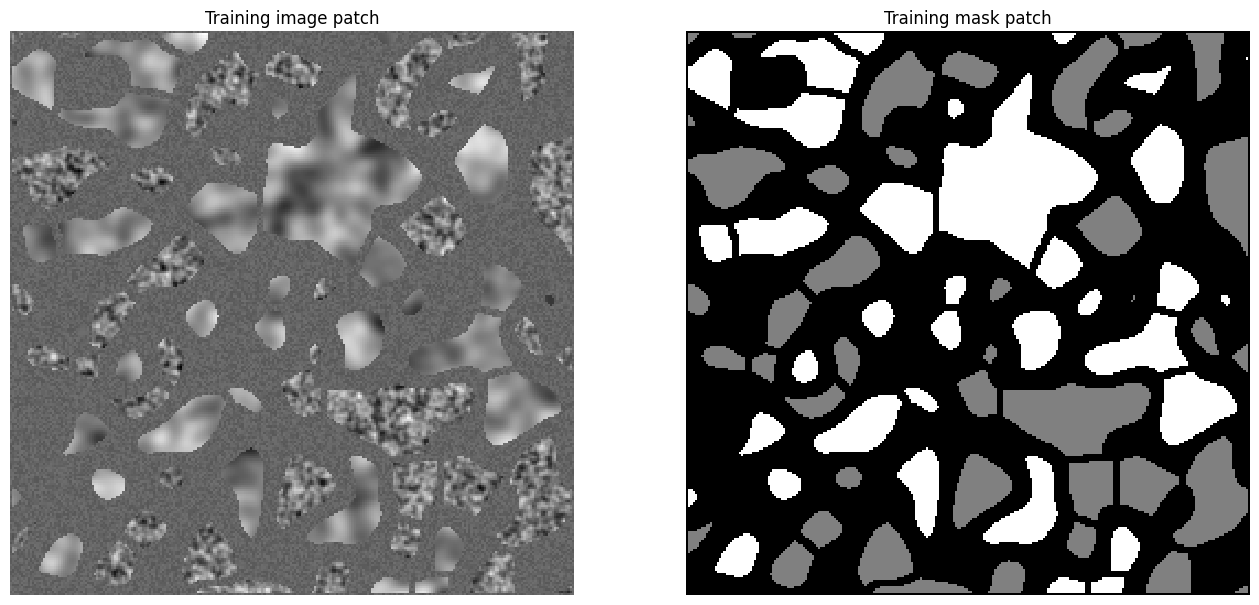

In [8]:
# ------------- Initial user input ------------
#@markdown ###Setup parameters
Training_source = '/content/gdrive/MyDrive/Colab Notebooks/workshops/datasets/simulation-3K-10im/train/sources' #@param {type:"string"}
Training_target = '/content/gdrive/MyDrive/Colab Notebooks/workshops/datasets/simulation-3K-10im/train/labels' #@param {type:"string"}

model_name = 'test_simulation_TF2.8' #@param {type:"string"}
model_path = '/content/gdrive/MyDrive/Colab Notebooks/workshops/models/' #@param {type:"string"}

labels = 3 #@param {type:"number"}


number_of_epochs =  10#@param {type:"number"}

#@markdown ###Advanced parameters
Use_Default_Advanced_Parameters = True #@param {type:"boolean"}

#@markdown - If not, please input:
batch_size =  5#@param {type:"integer"}
number_of_steps =  0#@param {type:"number"}
pooling_steps = 3 #@param [1,2,3,4]{type:"raw"}
initial_learning_rate = 0.0001 #@param {type:"number"}
patch_width =  512#@param{type:"number"}
patch_height =  512#@param{type:"number"}
percentage_validation =  10#@param{type:"number"}

#@markdown > <small>Minimum fraction of pixels being foreground for a selected patch to be considered valid. It should be between 0 and 1. Default value: 0.05 (5%)
min_fraction = 0.05#@param{type:"number"}


# ------------- Initialising folder, variables and failsafes ------------
#  Create the folders where to save the model and the QC
full_model_path = os.path.join(model_path, model_name)
if os.path.exists(full_model_path):
  print(R+'!! WARNING: Folder already exists and will be overwritten !!'+W)

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  batch_size = 4
  pooling_steps = 2
  percentage_validation = 10
  initial_learning_rate = 0.0003
  patch_width, patch_height = estimatePatchSize(Training_source)
  min_fraction = 0.02


#The create_patches function will create the two folders below
# Patch_source = '/content/img_patches'
# Patch_target = '/content/mask_patches'
print('Training on patches of size (x,y): ('+str(patch_width)+','+str(patch_height)+')')

#Create patches
print('Creating patches...')
Patch_source, Patch_target = create_patches(Training_source, Training_target, patch_width, patch_height, min_fraction)

number_of_training_dataset = len(os.listdir(Patch_source))
print('Total number of valid patches: '+str(number_of_training_dataset))

if Use_Default_Advanced_Parameters or number_of_steps == 0:
  number_of_steps = ceil((100-percentage_validation)/100*number_of_training_dataset/batch_size)
print('Number of steps: '+str(number_of_steps))

# Calculate the number of steps to use for validation
validation_steps = max(1, ceil(percentage_validation/100*number_of_training_dataset/batch_size))
validatio_split = percentage_validation/100

# Here we disable pre-trained model by default (in case the next cell is not ran)
Use_pretrained_model = False
# Here we disable data augmentation by default (in case the cell is not ran)
Use_Data_augmentation = False
# Build the default dict for the ImageDataGenerator
data_gen_args = dict(width_shift_range = 0.,
                     height_shift_range = 0.,
                     rotation_range = 0., #90
                     zoom_range = 0.,
                     shear_range = 0.,
                     horizontal_flip = False,
                     vertical_flip = False,
                     validation_split = percentage_validation/100,
                     fill_mode = 'reflect')

# ------------- Display ------------

#if not os.path.exists('/content/img_patches/'):
random_choice = random.choice(os.listdir(Patch_source))
x = io.imread(os.path.join(Patch_source, random_choice))

#os.chdir(Training_target)
y = io.imread(os.path.join(Patch_target, random_choice), as_gray=True)

f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(x, interpolation='nearest',cmap='gray')
plt.title('Training image patch')
plt.axis('off');

plt.subplot(1,2,2)
plt.imshow(y, interpolation='nearest',cmap='gray')
plt.title('Training mask patch')
plt.axis('off');

plt.savefig(base_path + '/TrainingDataExample_Unet2D.png',bbox_inches='tight',pad_inches=0)



##**3.2. Data augmentation**

---

Augmentation options (value set to 0 cancel this option)


* **shift**: a translation by a fraction of the image size (width or height), **default: 10%**
* **zoom_range**: Increasing or decreasing the field of view. E.g. 10% will result in a zoom range of (0.9 to 1.1), with pixels added or interpolated, **default: 10%**
* **shear_range**: Shear angle in counter-clockwise direction, **default: 10%**
* **flip**: Mirror image along (horizontal or vertical), **default: True**
* **rotation_range**: range of allowed rotation angles in degrees (from 0 to *value*), **default: 180**

Parameters enabled
Here is what a subset of your augmentations looks like:


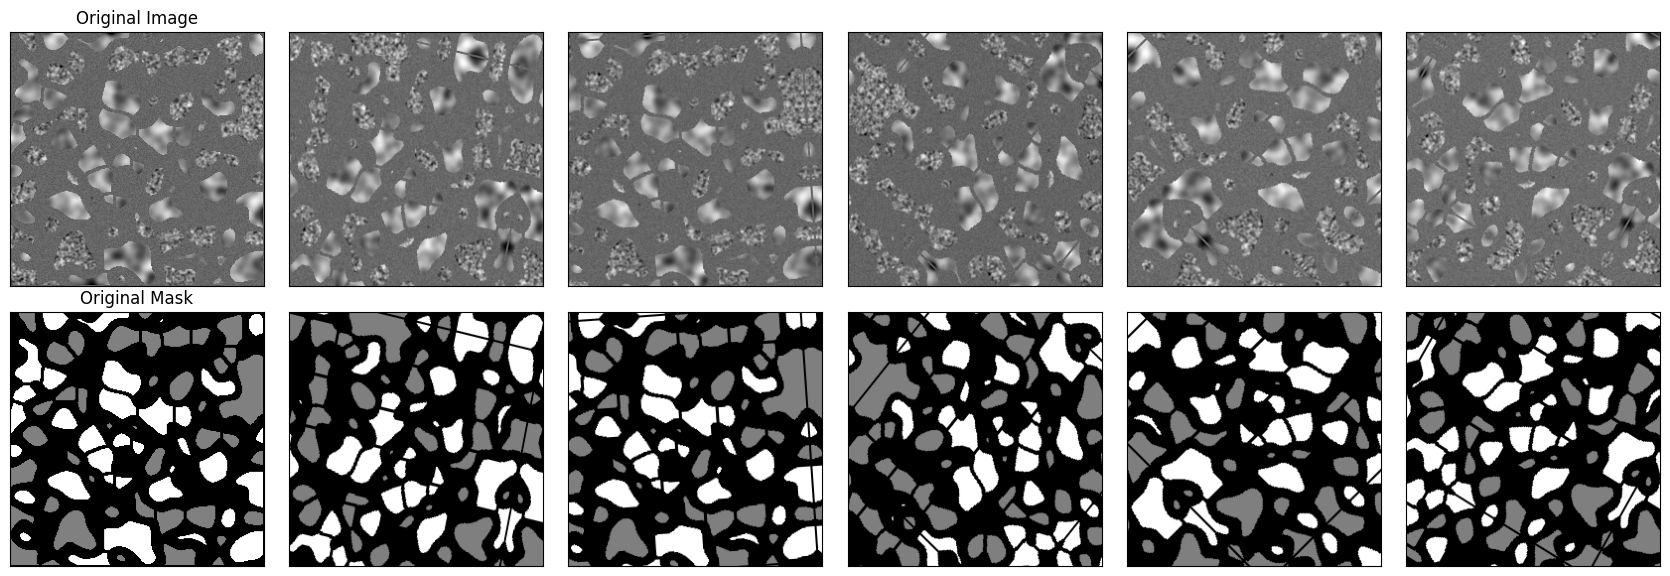

In [9]:
#@markdown ## Run data augmentation

Use_Data_augmentation = True #@param {type:"boolean"}
Use_Default_Augmentation_Parameters = True #@param {type:"boolean"}

if Use_Data_augmentation:
  if Use_Default_Augmentation_Parameters:
    horizontal_shift =  10
    vertical_shift =  20
    zoom_range =  10
    shear_range =  10
    horizontal_flip = True
    vertical_flip = True
    rotation_range =  180
#@markdown ###If you are not using the default settings, please provide the values below:

  else:
    horizontal_shift =  10 #@param {type:"slider", min:0, max:100, step:1}
    vertical_shift =  0 #@param {type:"slider", min:0, max:100, step:1}
    zoom_range =  10 #@param {type:"slider", min:0, max:100, step:1}
    shear_range =  14 #@param {type:"slider", min:0, max:100, step:1}
    horizontal_flip = True #@param {type:"boolean"}
    vertical_flip = True #@param {type:"boolean"}
    rotation_range =  180 #@param {type:"slider", min:0, max:180, step:1}

#given behind the # are the default values for each parameter.

else:
  horizontal_shift =  0
  vertical_shift =  0
  zoom_range =  0
  shear_range =  0
  horizontal_flip = False
  vertical_flip = False
  rotation_range =  0


# Build the dict for the ImageDataGenerator
data_gen_args = dict(width_shift_range = horizontal_shift/100.,
                     height_shift_range = vertical_shift/100.,
                     rotation_range = rotation_range, #90
                     zoom_range = zoom_range/100.,
                     shear_range = shear_range/100.,
                     horizontal_flip = horizontal_flip,
                     vertical_flip = vertical_flip,
                     validation_split = percentage_validation/100,
                     fill_mode = 'reflect')



# ------------- Display ------------
dir_augmented_data_imgs = base_path + "/augment_img"
dir_augmented_data_masks = base_path + "/augment_mask"
random_choice = random.choice(os.listdir(Patch_source))
orig_img = load_img(os.path.join(Patch_source,random_choice))
orig_mask = load_img(os.path.join(Patch_target,random_choice))

augment_view = ImageDataGenerator(**data_gen_args)

if Use_Data_augmentation:
  print("Parameters enabled")
  print("Here is what a subset of your augmentations looks like:")
  save_augment(augment_view, orig_img, dir_augmented_data=dir_augmented_data_imgs)
  save_augment(augment_view, orig_mask, dir_augmented_data=dir_augmented_data_masks)

  fig = plt.figure(figsize=(15, 7))
  fig.subplots_adjust(hspace=0.0,wspace=0.1,left=0,right=1.1,bottom=0, top=0.8)


  ax = fig.add_subplot(2, 6, 1,xticks=[],yticks=[])
  new_img=img_as_ubyte(normalizeMinMax(img_to_array(orig_img)))
  ax.imshow(new_img)
  ax.set_title('Original Image')
  i = 2
  for imgnm in os.listdir(dir_augmented_data_imgs):
    ax = fig.add_subplot(2, 6, i,xticks=[],yticks=[])
    img = load_img(dir_augmented_data_imgs + "/" + imgnm)
    ax.imshow(img)
    i += 1

  ax = fig.add_subplot(2, 6, 7,xticks=[],yticks=[])
  new_mask=img_as_ubyte(normalizeMinMax(img_to_array(orig_mask)))
  ax.imshow(new_mask)
  ax.set_title('Original Mask')
  j=2
  for imgnm in os.listdir(dir_augmented_data_masks):
    ax = fig.add_subplot(2, 6, j+6,xticks=[],yticks=[])
    mask = load_img(dir_augmented_data_masks + "/" + imgnm)
    ax.imshow(mask)
    j += 1
  plt.show()

else:
  print("No augmentation will be used")




## **3.3. Setup a pre-trained model for fine-tuning (optional)**
---
Set the the path to a pre-trained model from which the weights can be extracted and used as a starting point for this training session. This pre-trained model needs to be a U-Net model.

**You do not need to run this section if you want to train a network from scratch**.

> <small>**Note** For exemple, this option allows you to use pre-trained models from the [BioImage Model Zoo](https://bioimage.io/#/) and fine-tune them to analyse new data. Choose `bioimageio_model` and provide the ID in `bioimageio_model_id` (e.g., "creative-panda" or "10.5281/zenodo.5817052").

> <small>**Note** In order to continue training, it is adviseable to also load the learning rate that was used when the training ended. This is automatically saved for models trained with ZeroCostDL4Mic and will be loaded here. If no learning rate can be found in the model folder provided, the default learning rate will be used.

In [10]:
# @markdown ##Load a pre-trained model for fune-tuning

Use_pretrained_model = False #@param {type:"boolean"}
pretrained_model_choice = "BioImage Model Zoo" #@param ["Model_from_file", "BioImage Model Zoo"]
Weights_choice = "best" #@param ["last", "best"]


#@markdown ###If you chose "Model_from_file", please provide the path to the model folder:
pretrained_model_path = "" #@param {type:"string"}

#@markdown ###If you chose "BioImage Model Zoo", please provide the path or the URL to the model:
bioimageio_model_id = "" #@param {type:"string"}

# --------------------- Check if we load a previously trained model ------------------------
if Use_pretrained_model:

# --------------------- Load the model from the choosen path ------------------------
  if pretrained_model_choice == "Model_from_file":
    h5_file_path = os.path.join(pretrained_model_path, "weights_"+Weights_choice+".hdf5")
    qc_path = os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv')
  elif pretrained_model_choice == "BioImage Model Zoo":

    model_spec = load_resource_description(bioimageio_model_id)
    if "keras_hdf5" not in biomodel.weights:
      print("Invalid bioimageio model")
      h5_file_path = "no-model"
      qc_path = "no-qc"
    else:
      h5_file_path = str(biomodel.weights["keras_hdf5"].source)
      try:
        attachments = biomodel.attachments.files
        qc_path = [fname for fname in attachments if fname.endswith("training_evaluation.csv")][0]
        qc_path = os.path.join(base_path + "//bioimageio_pretrained_model", qc_path)
      except Exception:
        qc_path = "no-qc"

# --------------------- Check the model exist ------------------------
# If the model path chosen does not contain a pretrain model then use_pretrained_model is disabled,
  if not os.path.exists(h5_file_path):
    print(R+'WARNING: pretrained model does not exist')
    Use_pretrained_model = False


# If the model path contains a pretrain model, we load the training rate,
  if os.path.exists(h5_file_path):
#Here we check if the learning rate can be loaded from the quality control folder
    # if os.path.exists(os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv')):
    if os.path.exists(qc_path):

      # with open(os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv'),'r') as csvfile:
      with open(qc_path,'r') as csvfile:
        csvRead = pd.read_csv(csvfile, sep=',')
        #print(csvRead)

        if "learning rate" in csvRead.columns: #Here we check that the learning rate column exist (compatibility with model trained un ZeroCostDL4Mic bellow 1.4)
          print("pretrained network learning rate found")
          #find the last learning rate
          lastLearningRate = csvRead["learning rate"].iloc[-1]
          #Find the learning rate corresponding to the lowest validation loss
          min_val_loss = csvRead[csvRead['val_loss'] == min(csvRead['val_loss'])]
          #print(min_val_loss)
          bestLearningRate = min_val_loss['learning rate'].iloc[-1]

          if Weights_choice == "last":
            print('Last learning rate: '+str(lastLearningRate))

          if Weights_choice == "best":
            print('Learning rate of best validation loss: '+str(bestLearningRate))

        if not "learning rate" in csvRead.columns: #if the column does not exist, then initial learning rate is used instead
          bestLearningRate = initial_learning_rate
          lastLearningRate = initial_learning_rate
          print(bcolors.WARNING+'WARNING: The learning rate cannot be identified from the pretrained network. Default learning rate of '+str(bestLearningRate)+' will be used instead' + W)

#Compatibility with models trained outside ZeroCostDL4Mic but default learning rate will be used
    if not os.path.exists(os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv')):
      print(bcolors.WARNING+'WARNING: The learning rate cannot be identified from the pretrained network. Default learning rate of '+str(initial_learning_rate)+' will be used instead'+ W)
      bestLearningRate = initial_learning_rate
      lastLearningRate = initial_learning_rate


# Display info about the pretrained model to be loaded (or not)
if Use_pretrained_model:
  print('Weights found in:')
  print(h5_file_path)
  print('will be loaded prior to training.')

else:
  print(R+'No pretrained network will be used.')



No pretrained network will be used.



# **4. Training**
---

## **4.1. Prepare the model for training**
---
<font size = 4>Here, we use the information from 3. to build the model and convert the training data into a suitable format for training.

In [11]:
#@markdown ##Prepare the model for training


# ------------------ Set the generators, model and logger ------------------
# This will take the image size and set that as a patch size (arguable...)
# Read image size (without actuall reading the data)

(train_datagen, validation_datagen) = prepareGenerators(Patch_source,
                                                        Patch_target,
                                                        data_gen_args,
                                                        batch_size,
                                                        target_size = (patch_width, patch_height),
                                                        validatio_split = validatio_split)


# This modelcheckpoint will only save the best model from the validation loss point of view
model_checkpoint = ModelCheckpoint(os.path.join(full_model_path, 'weights_best.hdf5'),
                                   monitor='val_loss',verbose=1, save_best_only=True)

# --------------------- Using pretrained model ------------------------
#Here we ensure that the learning rate set correctly when using pre-trained models
if Use_pretrained_model:
  if Weights_choice == "last":
    initial_learning_rate = lastLearningRate

  if Weights_choice == "best":
    initial_learning_rate = bestLearningRate
else:
  h5_file_path = None

# --------------------- ---------------------- ------------------------

# --------------------- Reduce learning rate on plateau ------------------------

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1,
                              mode='auto', patience=20, min_lr=0)
# --------------------- ---------------------- ------------------------

# Define the model
model = unet(input_size = (patch_width,patch_height,1),
            pooling_steps = pooling_steps,
            learning_rate = initial_learning_rate,
            labels = labels)

# --------------------- Using pretrained model ------------------------
# Load the pretrained weights
if Use_pretrained_model:
  try:
      model.load_weights(h5_file_path)
  except:
      print(bcolors.WARNING + "The pretrained model could not be loaded as the configuration of the network is different.")
      print("Please, read the model specifications and check the parameters in Section 3.1" + W)

# except:
#   print("The pretrained model could not be loaded. Please, check the parameters of the pre-trained model architecture.")
config_model= model.optimizer.get_config()
print(config_model)


# ------------------ Failsafes ------------------
if os.path.exists(full_model_path):
  print(R+'!! WARNING: Model folder already existed and has been removed !!'+W)
  shutil.rmtree(full_model_path)

os.makedirs(full_model_path)
os.makedirs(os.path.join(full_model_path,'Quality Control'))


# ------------------ Display ------------------
print('---------------------------- Main training parameters ----------------------------')
print('Number of epochs: '+str(number_of_epochs))
print('Batch size: '+str(batch_size))
print('Number of training dataset: '+str(number_of_training_dataset))
print('Number of training steps: '+str(number_of_steps))
print('Number of validation steps: '+str(validation_steps))
print('---------------------------- ------------------------ ----------------------------')

pdf_export(augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

## **4.2. Start Training**
---
When playing the cell below you should see updates after each epoch (round). Network training can take some time.
Once training is complete, the trained model is automatically saved on your Google Drive, in the **model_path**.

[codecarbon WARNING @ 14:59:12] Already started tracking


Found 9 images belonging to 1 classes.
Found 9 images belonging to 1 classes.
Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 3.3330Found 1 images belonging to 1 classes.
Found 1 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 1.33111, saving model to /content/gdrive/MyDrive/Colab Notebooks/workshops/models/test_simulation_TF2.8/weights_best.hdf5


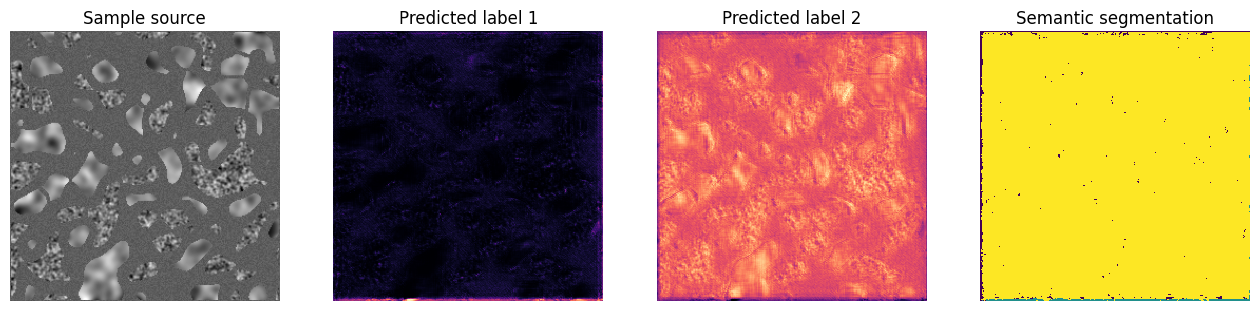

3/3 [==============================] - 9s 2s/step - loss: 3.3330 - val_loss: 1.3311 - lr: 3.0000e-04
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 1.2169
Epoch 2: val_loss improved from 1.33111 to 1.10695, saving model to /content/gdrive/MyDrive/Colab Notebooks/workshops/models/test_simulation_TF2.8/weights_best.hdf5
3/3 [==============================] - 1s 357ms/step - loss: 1.2169 - val_loss: 1.1069 - lr: 3.0000e-04
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 1.0655
Epoch 3: val_loss improved from 1.10695 to 0.96656, saving model to /content/gdrive/MyDrive/Colab Notebooks/workshops/models/test_simulation_TF2.8/weights_best.hdf5
3/3 [==============================] - 1s 302ms/step - loss: 1.0655 - val_loss: 0.9666 - lr: 3.0000e-04
Epoch 4/10
2/3 [===================>..........] - ETA: 0s - loss: 1.0123
Epoch 4: val_loss improved from 0.96656 to 0.92135, saving model to /content/gdrive/MyDrive/Colab Notebooks/workshops/models/test_simulation_T

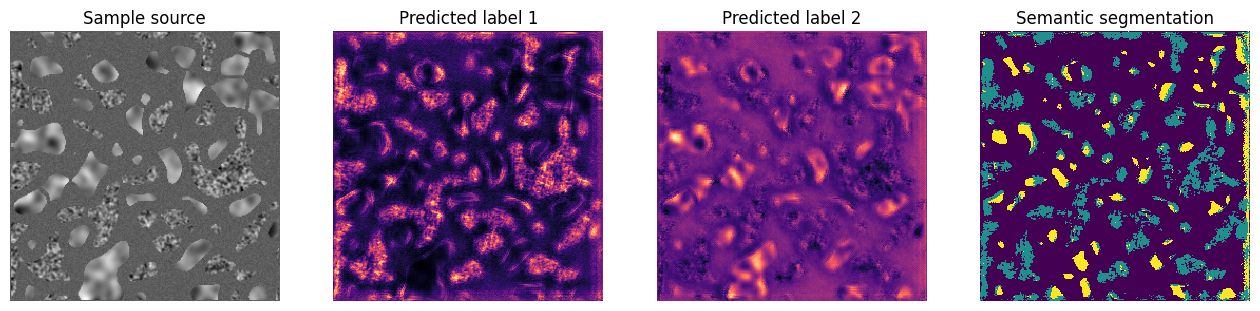

3/3 [==============================] - 1s 455ms/step - loss: 0.9107 - val_loss: 0.7580 - lr: 3.0000e-04
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 0.7934
Epoch 7: val_loss improved from 0.75803 to 0.68104, saving model to /content/gdrive/MyDrive/Colab Notebooks/workshops/models/test_simulation_TF2.8/weights_best.hdf5
3/3 [==============================] - 1s 265ms/step - loss: 0.7934 - val_loss: 0.6810 - lr: 3.0000e-04
Epoch 8/10
2/3 [===================>..........] - ETA: 0s - loss: 0.7092
Epoch 8: val_loss improved from 0.68104 to 0.64875, saving model to /content/gdrive/MyDrive/Colab Notebooks/workshops/models/test_simulation_TF2.8/weights_best.hdf5
3/3 [==============================] - 1s 254ms/step - loss: 0.7079 - val_loss: 0.6488 - lr: 3.0000e-04
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 0.8004
Epoch 9: val_loss did not improve from 0.64875
3/3 [==============================] - 1s 171ms/step - loss: 0.8004 - val_loss: 0.6558 - lr:

[codecarbon WARNING @ 14:59:33] Tracker already stopped !
[codecarbon WARNING @ 14:59:33] Background scheduler didn't run for a long period (86s), results might be inaccurate
[codecarbon INFO @ 14:59:33] Energy consumed for RAM : 0.000116 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 14:59:33] Energy consumed for all GPUs : 0.000790 kWh. Total GPU Power : 32.48738859416506 W
[codecarbon INFO @ 14:59:33] Energy consumed for all CPUs : 0.001037 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 14:59:33] 0.001943 kWh of electricity used since the beginning.


------------------------------------------
Time elapsed: 0.0 hour(s) 0.0 min(s) 22 sec(s)
------------------------------------------
------------------------------
PDF report exported in /content/gdrive/MyDrive/Colab Notebooks/workshops/models//test_simulation_TF2.8/


In [12]:
#@markdown ##Start training

start = time.time()

random_choice = random.choice(os.listdir(Patch_source))
x = io.imread(os.path.join(Patch_source, random_choice))
sample_batch = np.expand_dims(normalizePercentile(x), axis = [0, -1])
sample_img = SampleImageCallback(model, sample_batch, os.path.join(model_path, model_name))

if Use_carbon_emission_tracker == True:
  with tracker:
    history = model.fit_generator(train_datagen, steps_per_epoch = number_of_steps,
                              epochs = number_of_epochs, callbacks=[model_checkpoint, reduce_lr, sample_img], validation_data = validation_datagen, validation_steps = 3, shuffle=True, verbose=1)
else:
  history = model.fit_generator(train_datagen, steps_per_epoch = number_of_steps,
                              epochs = number_of_epochs, callbacks=[model_checkpoint, reduce_lr, sample_img], validation_data = validation_datagen, validation_steps = 3, shuffle=True, verbose=1)


# Save the last model
model.save(os.path.join(full_model_path, 'weights_last.hdf5'))


# convert the history.history dict to a pandas DataFrame:
lossData = pd.DataFrame(history.history)

# The training evaluation.csv is saved (overwrites the Files if needed).
lossDataCSVpath = os.path.join(full_model_path,'Quality Control/training_evaluation.csv')
with open(lossDataCSVpath, 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['loss','val_loss', 'learning rate'])
  for i in range(len(history.history['loss'])):
    writer.writerow([history.history['loss'][i], history.history['val_loss'][i], history.history['lr'][i]])



# Displaying the time elapsed for training
print("------------------------------------------")
dt = time.time() - start
mins, sec = divmod(dt, 60)
hour, mins = divmod(mins, 60)
print("Time elapsed:", hour, "hour(s)", mins,"min(s)",round(sec),"sec(s)")
print("------------------------------------------")

#Create a pdf document with training summary

pdf_export(trained = True, augmentation = Use_Data_augmentation, pretrained_model = Use_pretrained_model)


# **5. Evaluate your model**
---




In [13]:
#@markdown ###Do you want to assess the model you just trained ?

Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, please provide the path to the model folder:

QC_model_folder = "" #@param {type:"string"}

#Here we define the loaded model name and path
QC_model_name = os.path.basename(QC_model_folder)
QC_model_path = os.path.dirname(QC_model_folder)


if (Use_the_current_trained_model):
  print("Using current trained network")
  QC_model_name = model_name
  QC_model_path = model_path
else:
  # These are used in section 6
  model_name = QC_model_name
  model_path = QC_model_path

full_QC_model_path = os.path.join(QC_model_path, QC_model_name)
if os.path.exists(os.path.join(full_QC_model_path, 'weights_best.hdf5')):
  print("The "+QC_model_name+" network will be evaluated")
else:
  print(R+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path and model name before proceeding further.')



Using current trained network
The test_simulation_TF2.8 network will be evaluated


## **5.1. Inspection of the loss function**
---

<font size = 4>**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

<font size = 4>**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.


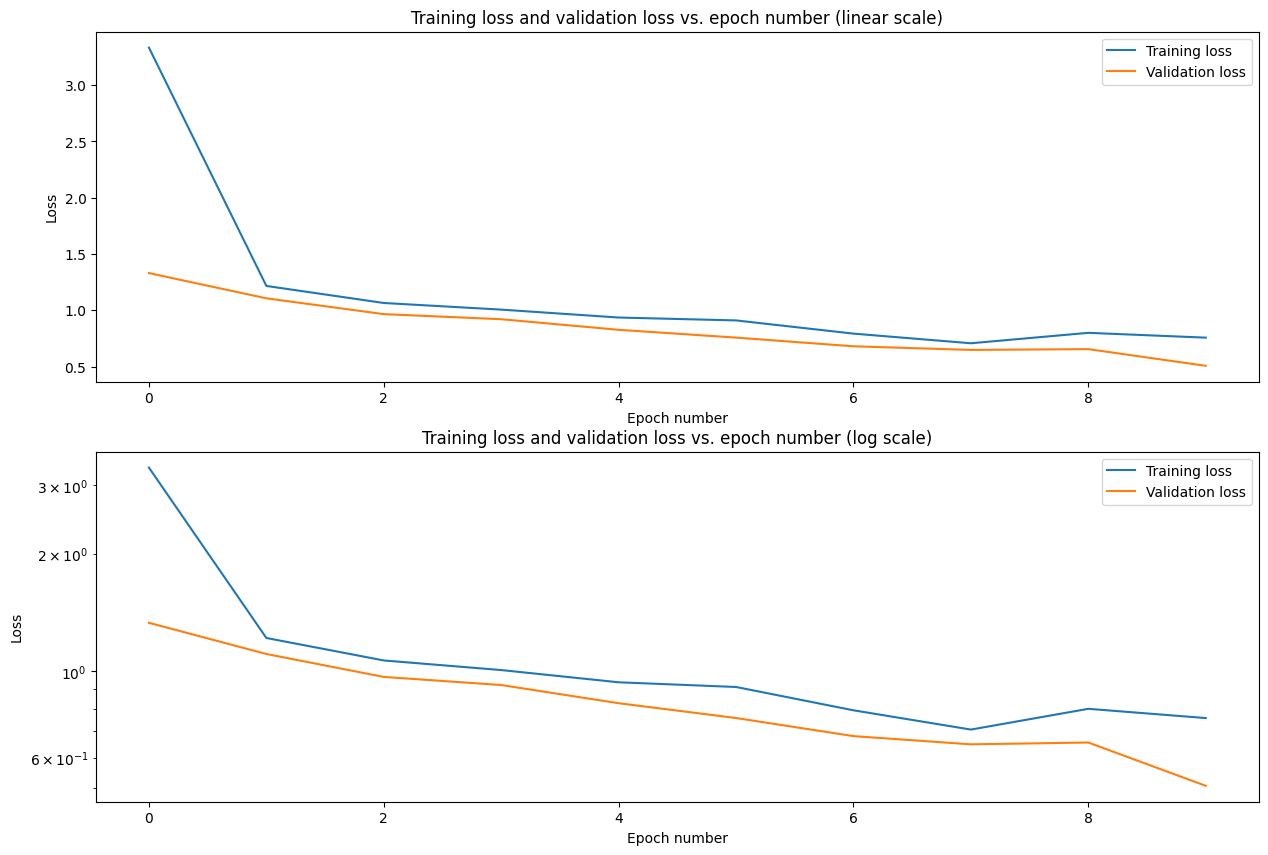

In [14]:
#@markdown ## Plot the training curves

epochNumber = []
lossDataFromCSV = []
vallossDataFromCSV = []

with open(os.path.join(full_QC_model_path, 'Quality Control', 'training_evaluation.csv'),'r') as csvfile:
    csvRead = csv.reader(csvfile, delimiter=',')
    next(csvRead)
    for row in csvRead:
        lossDataFromCSV.append(float(row[0]))
        vallossDataFromCSV.append(float(row[1]))

epochNumber = range(len(lossDataFromCSV))

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(epochNumber,lossDataFromCSV, label='Training loss')
plt.plot(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(epochNumber,lossDataFromCSV, label='Training loss')
plt.semilogy(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()
plt.savefig(os.path.join(full_QC_model_path, 'Quality Control', 'lossCurvePlots.png'),bbox_inches='tight',pad_inches=0)
plt.show()



## **5.2. Error mapping and quality metrics estimation**
---
This section calculates the Intersection over Union score for all the images provided in the Source_QC_folder and Target_QC_folder. The results for all QC examples can be found in the "*Quality Control*" folder which is located inside your "model_folder"

> Note: The **Intersection over Union** metric is a method that can be used to quantify the percent overlap between the target mask and your prediction output. **Therefore, the closer to 1, the better the performance.** This metric can be used to assess the quality of your model to accurately predict nuclei.


### **Thresholds for image masks**

Since the output from Unet is not a binary mask, the output images are converted to binary masks using thresholding. This section will test different thresholds (from 0 to 255) to find the one yielding the best IoU score compared with the ground truth. The best threshold for each image and the average of these thresholds will be displayed below. **These values can be a guideline when creating masks for unseen data in section 6.**

Model input size: 256x256
Number of dataset found in the folder: 10


  0%|          | 0/10 [00:00<?, ?it/s]

0000.png
0001.png
0002.png
0003.png
0004.png
0005.png
0006.png
0007.png
0008.png
0009.png
Running QC on: 0000.png
Running QC on: 0001.png
Running QC on: 0002.png
Running QC on: 0003.png
Running QC on: 0004.png
Running QC on: 0005.png
Running QC on: 0006.png
Running QC on: 0007.png
Running QC on: 0008.png
Running QC on: 0009.png
--------------------------------------------------------------


interactive(children=(Dropdown(description='file', options=('0000.png', '0001.png', '0002.png', '0003.png', '0…

------------------------------
QC PDF report exported as /content/gdrive/MyDrive/Colab Notebooks/workshops/models/test_simulation_TF2.8/Quality Control/test_simulation_TF2.8_QC_report.pdf


,IoU
0000.png,0.662376
0001.png,0.647735
0002.png,0.641920
0003.png,0.653825
0004.png,0.631655


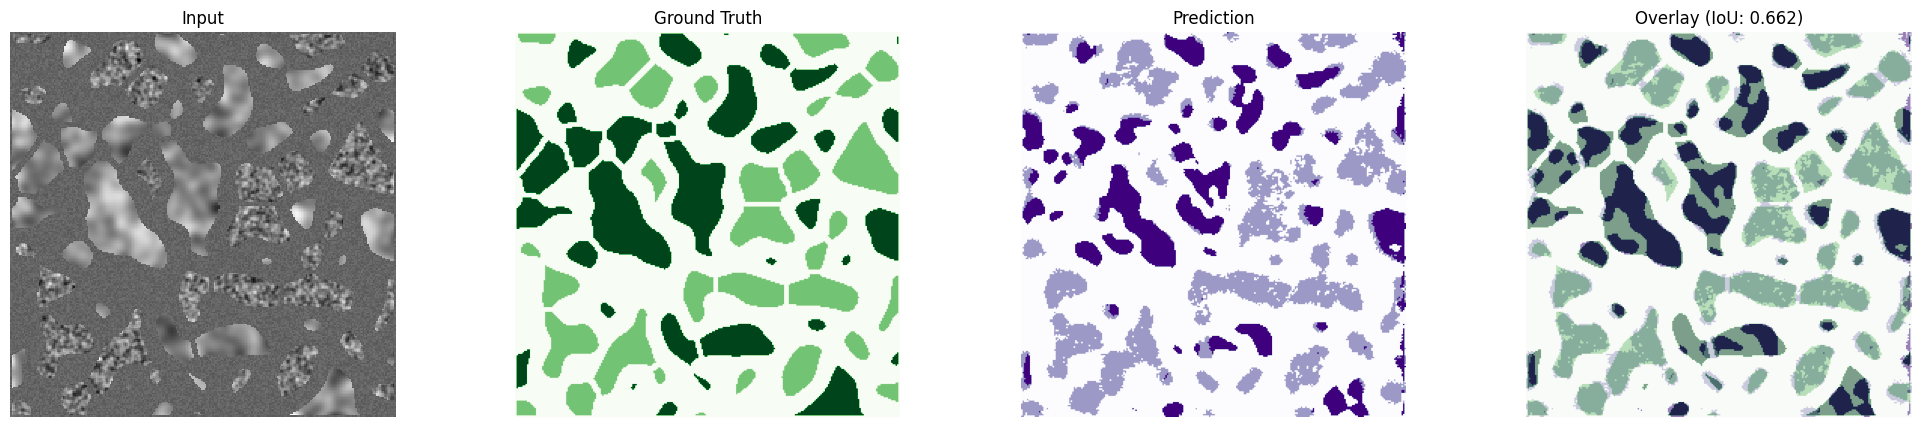

In [15]:
# ------------- User input ------------
#@markdown ##Choose the folders that contain your Quality Control dataset
Source_QC_folder = "/content/gdrive/MyDrive/Colab Notebooks/workshops/datasets/simulation-3K-10im/test/sources" #@param{type:"string"}
Target_QC_folder = "/content/gdrive/MyDrive/Colab Notebooks/workshops/datasets/simulation-3K-10im/test/labels" #@param{type:"string"}


# ------------- Initialise folders ------------
# Create a quality control/Prediction Folder
prediction_QC_folder = os.path.join(full_QC_model_path, 'Quality Control', 'Prediction')
if os.path.exists(prediction_QC_folder):
  shutil.rmtree(prediction_QC_folder)

os.makedirs(prediction_QC_folder)


# ------------- Prepare the model and run predictions ------------

# Load the model
unet = load_model(os.path.join(full_QC_model_path, 'weights_best.hdf5'), custom_objects={'_weighted_binary_crossentropy': weighted_binary_crossentropy(np.ones(2))})
labels =  unet.output_shape[-1]
Input_size = unet.layers[0].output_shape[0][1:3]
print('Model input size: '+str(Input_size[0])+'x'+str(Input_size[1]))

# Create a list of sources
source_dir_list = os.listdir(Source_QC_folder)
number_of_dataset = len(source_dir_list)
print('Number of dataset found in the folder: '+str(number_of_dataset))

predictions = []
for i in tqdm(range(number_of_dataset)):
  predictions.append(predict_as_tiles(os.path.join(Source_QC_folder, source_dir_list[i]), unet))


# Save the results in the folder along with the masks according to the set threshold
saveResult(prediction_QC_folder, predictions, source_dir_list, prefix=prediction_prefix)

#-----------------------------Calculate Metrics----------------------------------------#

# Here we start testing the differences between GT and predicted masks

with open(QC_model_path+'/'+QC_model_name+'/Quality Control/QC_metrics_'+QC_model_name+".csv", "w", newline='') as file:
    writer = csv.writer(file, delimiter=",")
    stats_columns = ["image"]

    for l in range(labels):
        stats_columns.append("Prediction v. GT IoU label = {}".format(l))
    stats_columns.append("Prediction v. GT averaged IoU")
    writer.writerow(stats_columns)
    # Initialise the lists
    filename_list = []
    iou_score_list = []
    for filename in os.listdir(Source_QC_folder):
        if not os.path.isdir(os.path.join(Source_QC_folder, filename)):
            print('Running QC on: '+filename)

            test_input = io.imread(os.path.join(Source_QC_folder, filename), as_gray=True)
            test_ground_truth_image = io.imread(os.path.join(Target_QC_folder, filename), as_gray=True)
            test_prediction = io.imread(os.path.join(prediction_QC_folder, prediction_prefix + filename))

            iou_labels = [filename]
            iou_score = 0.
            for l in range(labels):
                aux_gt = (test_ground_truth_image==l).astype(np.uint8)
                aux_pred = (test_prediction==l).astype(np.uint8)
                intersection = np.logical_and(aux_gt, aux_pred)
                union = np.logical_or(aux_gt, aux_pred)

                iou_labels.append(str(np.sum(intersection) / np.sum(union)))
                iou_score +=  np.sum(intersection) / np.sum(union)
            filename_list.append(filename)
            iou_score_list.append(iou_score/labels)
            iou_labels.append(str(iou_score/labels))
            writer.writerow(iou_labels)
    file.close()

## Create a display of the results

# Table with metrics as dataframe output
pdResults = pd.DataFrame(index = filename_list)
pdResults["IoU"] = iou_score_list

# ------------- For display ------------
print('--------------------------------------------------------------')
@interact
def show_QC_results(file=os.listdir(Source_QC_folder)):

  plt.figure(figsize=(25,5))
  #Input
  plt.subplot(1,4,1)
  plt.axis('off')
  plt.imshow(plt.imread(os.path.join(Source_QC_folder, file)), aspect='equal', cmap='gray', interpolation='nearest')
  plt.title('Input')

  #Ground-truth
  plt.subplot(1,4,2)
  plt.axis('off')
  test_ground_truth_image = io.imread(os.path.join(Target_QC_folder, file),as_gray=True)
  plt.imshow(test_ground_truth_image, aspect='equal', cmap='Greens')
  plt.title('Ground Truth')

  #Prediction
  plt.subplot(1,4,3)
  plt.axis('off')
  test_prediction = plt.imread(os.path.join(prediction_QC_folder, prediction_prefix+file))
  plt.imshow(test_prediction, aspect='equal', cmap='Purples')
  plt.title('Prediction')

  #Overlay
  plt.subplot(1,4,4)
  plt.axis('off')
  plt.imshow(test_ground_truth_image, cmap='Greens')
  plt.imshow(test_prediction, alpha=0.5, cmap='Purples')
  metrics_title = 'Overlay (IoU: ' + str(round(pdResults.loc[file]["IoU"],3)) + ')'
  plt.title(metrics_title)
  plt.savefig(full_QC_model_path+'/Quality Control/QC_example_data.png',bbox_inches='tight',pad_inches=0)

qc_pdf_export()

pdResults.head()

## **5.3. Export your model to the BioImage Model Zoo format**
---
This section exports the model to the [BioImage Model Zoo](https://bioimage.io/#/) format so it can be used directly with deepImageJ or Ilastik. The new files will be stored in the model folder specified at the beginning of Section 5.

Once the cell is executed, you will find a new zip file with the name specified in `trained_model_name.bioimage.io.model`.

The exported model contains an additional ImageJ macro (`Contours2InstanceSegmentation.ijm`) to obtain a unique 2D image with the different labels and also identify each independent object in the image.

More information at https://deepimagej.github.io/deepimagej/

In [16]:
# ------------- User input ------------
# information about the model
#@markdown ## Information to document your model:
Trained_model_name    = "Simulation_10E_TF.2.8" #@param {type:"string"}
Trained_model_authors =  "[Author 1 name, Author 2 name]" #@param {type:"string"}
Trained_model_authors_affiliation =  "[Author affiliation, Author 2 affiliation]" #@param {type:"string"}
Trained_model_description = "" #@param {type:"string"}
Trained_model_license = 'MIT'#@param {type:"string"}
Trained_model_references = ["Falk et al. Nature Methods 2019", "Ronneberger et al. arXiv in 2015", "Lucas von Chamier et al. biorXiv 2020"]
Trained_model_DOI = ["https://doi.org/10.1038/s41592-018-0261-2","https://doi.org/10.1007/978-3-319-24574-4_28", "https://doi.org/10.1101/2020.03.20.000133"]

# Training data
# ---------------------------------------
#@markdown ##Include information about training data (optional):
include_training_data = True #@param {type: "boolean"}
#@markdown ### - If it is published in the BioImage Model Zoo, please, provide the ID
data_from_bioimage_model_zoo = True #@param {type: "boolean"}
training_data_ID = ''#@param {type:"string"}
#@markdown ### - If not, please provide the URL tot he data and a short description
training_data_source = ''#@param {type:"string"}
training_data_description = ''#@param {type:"string"}



# Add example image information
# ---------------------------------------
#@markdown ##Introduce the pixel size

PixelSize = 1 #@param {type:"number"}
#@markdown ##Do you want to choose the exampleimage?
default_example_image = True #@param {type:"boolean"}
#@markdown ###If not, please input:
fileID    =  "" #@param {type:"string"}
if default_example_image:
    fileID = os.path.join(Source_QC_folder, os.listdir(Source_QC_folder)[0])

# Load the model and process the example image
# ---------------------------------------
# Load the model
model = load_model(os.path.join(full_QC_model_path, 'weights_best.hdf5'),
                  custom_objects={'_weighted_binary_crossentropy': weighted_binary_crossentropy(np.ones(2))})
# ------------- Execute bioimage model zoo configuration ------------
# Create a model without compilation so it can be used in any other environment.
# remove the custom loss function from the model, so that it can be used outside of this notebook
unet = Model(model.input, model.output)
weight_path = os.path.join(full_QC_model_path, 'keras_weights.hdf5')
unet.save(weight_path)


# create the author spec input
auth_names = Trained_model_authors[1:-1].split(",")
auth_affs = Trained_model_authors_affiliation[1:-1].split(",")
assert len(auth_names) == len(auth_affs)
authors = [{"name": auth_name, "affiliation": auth_aff} for auth_name, auth_aff in zip(auth_names, auth_affs)]

# I would recommend using CCBY-4 as licencese
license = Trained_model_license

# where to save the model
output_root = os.path.join(full_QC_model_path, Trained_model_name + '.bioimage.io.model')
os.makedirs(output_root, exist_ok=True)
output_path = os.path.join(output_root, f"{Trained_model_name}.zip")

# create a markdown readme with information
readme_path = os.path.join(output_root, "README.md")
with open(readme_path, "w") as f:
  f.write("Visit https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")

# create the citation input spec
assert len(Trained_model_DOI) == len(Trained_model_references)
citations = [{'text': text, 'doi': doi} for text, doi in zip(Trained_model_references, Trained_model_DOI)]

# create the training data
if include_training_data:
    if data_from_bioimage_model_zoo:
      training_data = {"id": training_data_ID}
    else:
      training_data = {"source": training_data_source,
                       "description": training_data_description}
else:
    training_data={}

# create the input spec
def normalizePercentile(x, pmin=1, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)



min_percentile = 1
max_percentile = 99.8
shape = [sh for sh in unet.input.shape]
# batch should never be constrained
assert shape[0] is None
shape[0] = 1  # batch is set to 1 for bioimage.io
assert all(sh is not None for sh in shape)  # make sure all other shapes are fixed
pixel_size = {"x": PixelSize, "y": PixelSize}
kwargs = dict(
  input_names=["input"],
  input_axes=["bxyc"],
  pixel_sizes=[pixel_size],
  preprocessing=[[{"name": "scale_range", "kwargs": {"min_percentile": min_percentile,
                                  "max_percentile": max_percentile,
                                  "mode": "per_sample",
                                  "axes": "xyc"}}]])

shape = tuple(shape)

postprocessing = None

output_spec = dict(
  output_names=["output"],
  output_axes=["bxyc"],
  postprocessing=postprocessing,
  output_reference=["input"],
  output_scale=[[1,1,1,3]], # consider changing it if the input has more than one channel
  output_offset=[4*[0]]
)
kwargs.update(output_spec)

# load the input image, crop it if necessary, and save as numpy file
# The crop will be centered to get an image with some content.
test_img = io.imread(fileID, as_gray = True)


x_size = int(test_img.shape[0]/2)
x_size = x_size-int(shape[1]/2)

y_size = int(test_img.shape[1]/2)
y_size = y_size-int(shape[2]/2)
assert test_img.ndim == 2
test_img = test_img[x_size : x_size + shape[1],
                    y_size : y_size + shape[2]]

assert test_img.shape == shape[1:3], f"{test_img.shape}, {shape}"
# Save the test image
test_in_path = os.path.join(output_root, "test_input.npy")
np.save(test_in_path, test_img[None, ..., None])  # add batch and channel axis
# Normalize the image before adding batch and channel dimensions
test_img = normalizePercentile(test_img)
test_img = test_img[None, ..., None]
test_prediction = unet.predict(test_img)

# run prediction on the input image and save the result as expected output
test_prediction = np.squeeze(test_prediction)
assert test_prediction.ndim == 3
test_prediction = test_prediction[None, ...]  # add batch axis
test_out_path = os.path.join(output_root, "test_output.npy")
np.save(test_out_path, test_prediction)

# attach the QC report to the model (if it exists)
qc_path = os.path.join(full_QC_model_path, 'Quality Control', 'training_evaluation.csv')
if os.path.exists(qc_path):
  attachments = {"files": [qc_path]}
else:
  attachments = None

# Include a post-processing deepImageJ macro
macro = "Contours2InstanceSegmentation.ijm"
url = f"https://raw.githubusercontent.com/deepimagej/imagej-macros/master/{macro}"
path = os.path.join(output_root, macro)
with requests.get(url, stream=True) as r:
  text = r.text
  if text.startswith("4"):
      raise RuntimeError(f"An error occured when downloading {url}: {r.text}")
  with open(path, "w") as f:
      f.write(r.text)
attachments = {"files": attachments["files"] + [path]}

# export the model with keras weihgts
build_model(
    weight_uri=weight_path,
    test_inputs=[test_in_path],
    test_outputs=[test_out_path],
    name=Trained_model_name,
    description=Trained_model_description,
    authors=authors,
    tags=['zerocostdl4mic', 'deepimagej', 'segmentation', 'tem', 'unet'],
    license=license,
    documentation=readme_path,
    cite=citations,
    output_path=output_path,
    add_deepimagej_config=True,
    tensorflow_version=tf.__version__,
    attachments=attachments,
    training_data = training_data,
    **kwargs
)

# convert the keras weights to tensorflow and add them to the model
tf_weight_path = os.path.join(full_QC_model_path, "tf_weights")
# we need to make sure that the tf weight folder does not exist
if os.path.exists(tf_weight_path):
  rmtree(tf_weight_path)
convert_weights_to_tensorflow_saved_model_bundle(output_path, tf_weight_path + ".zip")
add_weights(output_path, tf_weight_path + ".zip", output_path, tensorflow_version=tf.__version__)

# check that the model works for keras and tensorflow
res = test_model(output_path, weight_format="keras_hdf5")
success = True
if res[-1]["error"] is not None:
  success = False
  print("test-model failed for keras weights:", res[-1]["error"])

res = test_model(output_path, weight_format="tensorflow_saved_model_bundle")
if res[-1]["error"] is not None:
  success = False
  print("test-model failed for tensorflow weights:", res[-1]["error"])

if success:
  print("The bioimage.io model was successfully exported to", output_path)
else:
  print("The bioimage.io model was exported to", output_path)
  print("Some tests of the model did not work! You can still download and test the model.")
  print("You can still download and test the model, but it may not work as expected.")

TensorFlow model exported to /content/gdrive/MyDrive/Colab Notebooks/workshops/models/test_simulation_TF2.8/tf_weights.zip


computing dataset statistics: 0it [00:00, ?it/s]
computing dataset statistics: 0it [00:00, ?it/s]


The bioimage.io model was successfully exported to /content/gdrive/MyDrive/Colab Notebooks/workshops/models/test_simulation_TF2.8/Simulation_10E_TF.2.8.bioimage.io.model/Simulation_10E_TF.2.8.zip


# **6. Prediction**

---


In [ ]:
#@markdown  ## **6.1 Prediction on unseen dataset**

#@markdown The current trained model (from section 4.1) can now be used to process images. If you want to use an older model, untick the **Use_the_current_trained_model** box and enter the name and path of the model to use.

#@markdown **`Data_folder`:** This folder should contain the input images.

#@markdown **`Result_folder`:** This folder will contain the predicted output images.



Data_folder = '' #@param {type:"string"}
Results_folder = '' #@param {type:"string"}

#@markdown ###Do you want to use the current trained model?
Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, please provide the path to the model folder:

Prediction_model_folder = "" #@param {type:"string"}

#Here we find the loaded model name and parent path
Prediction_model_name = os.path.basename(Prediction_model_folder)
Prediction_model_path = os.path.dirname(Prediction_model_folder)


# ------------- Failsafes ------------
if (Use_the_current_trained_model):
  print("Using current trained network")
  Prediction_model_name = model_name
  Prediction_model_path = model_path

full_Prediction_model_path = os.path.join(Prediction_model_path, Prediction_model_name)
if os.path.exists(full_Prediction_model_path):
  print("The "+Prediction_model_name+" network will be used.")
else:
  print(R+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path and model name before proceeding further.')


# ------------- Prepare the model and run predictions ------------

# Load the model and prepare generator



unet = load_model(os.path.join(Prediction_model_path, Prediction_model_name, 'weights_best.hdf5'), custom_objects={'_weighted_binary_crossentropy': weighted_binary_crossentropy(np.ones(2))})
Input_size = unet.layers[0].output_shape[1:3]
print('Model input size: '+str(Input_size[0])+'x'+str(Input_size[1]))

# Create a list of sources
source_dir_list = os.listdir(Data_folder)
number_of_dataset = len(source_dir_list)
print('Number of dataset found in the folder: '+str(number_of_dataset))

predictions = []
for i in tqdm(range(number_of_dataset)):
  predictions.append(predict_as_tiles(os.path.join(Data_folder, source_dir_list[i]), unet))
  # predictions.append(prediction(os.path.join(Data_folder, source_dir_list[i]), os.path.join(Prediction_model_path, Prediction_model_name)))


# Save the results in the folder along with the masks according to the set threshold
saveResult(Results_folder, predictions, source_dir_list, prefix=prediction_prefix)


# ------------- For display ------------
print('--------------------------------------------------------------')


def show_prediction_mask(file=os.listdir(Data_folder)):

  plt.figure(figsize=(10,6))
  # Wide-field
  plt.subplot(1,2,1)
  plt.axis('off')
  img_Source = plt.imread(os.path.join(Data_folder, file))
  plt.imshow(img_Source, cmap='gray')
  plt.title('Source image',fontsize=15)
  # Prediction
  plt.subplot(1,2,2)
  plt.axis('off')
  img_Prediction = plt.imread(os.path.join(Results_folder, prediction_prefix+file))
  plt.imshow(img_Prediction, cmap='gray')
  plt.title('Prediction',fontsize=15)

interact(show_prediction_mask);

